## Setup

In [1]:
from dotenv import load_dotenv
import os
from openai import OpenAI

load_dotenv()

assert "OPENAI_API_KEY" in os.environ, "No config file"

DEBUG = 0

## Helper Functions

In [8]:
from pdf2image import convert_from_path
from PIL import Image
import io
import base64
import pandas as pd
import json
import time
from pathlib import Path

def img2base64(image, image_format='PNG'):
    img_buffer = io.BytesIO()
    image.save(img_buffer, format=image_format)
    img_size = img_buffer.tell()
    img_base64 = base64.b64encode(img_buffer.getvalue()).decode()
    return img_base64


def pdf2img(pdf_path):
    return convert_from_path(pdf_path)


def optimize_img(img):
    return img.convert('1')

## OpenAI GPT-Vision based Parser

Notes about the implementation

1. Uses GPT4-Vision (I only have normal access w/o azure). 
2. There are file size limits and the input is just images. So the helper functions above convert pdf -> image.
3. `PROMPT` variable below lists out the task for the LLM. I didn't spend a lot of time iterating on it.

- PNG is used as the image format instead of JPG since it works better with numbers.
- Optimization to use black and white image if color image is too large (disabled for final pass). 

In [13]:
PROMPT = """
You are an OCR agent, your task is to extract text information from images with accuracy and attention to detail. When encountering amounts of money, be careful to correctly identify the currency symbols and not to confuse commas with numbers. In cases where there are multiple totals, prioritize dollar amounts.

From the provided image, extract the information and return a JSON object with the following keys:

1. receiver_name: Name of the Buyer 
2. supplier_name: Name of the Seller
3. invoice_total: Total amount of the Invoice, represented as a floating-point number
4. invoice_date: Date of the transaction, formatted as YYYY/MM/DD

Do not use markdown symbols like "```" or "```json" at the beginning or end of your response.
"""

client = OpenAI()

def parse_invoice_or_po(pages):
    b64_imgs = list(map(img2base64, pages))
    img_inputs = [
        {
          "type": "image_url",
          "image_url": {
            "url": f"data:image/jpeg;base64,{b64}",
            "detail": "high"
          },
        }
        for b64 in b64_imgs
    ]

    response = client.chat.completions.create(
        model="gpt-4-vision-preview",
        messages=[
            {
                "role": "user",
                "content": [
                    {"type": "text", "text": PROMPT},
                    *img_inputs
                ],
            }
        ],
        max_tokens=4096,
        temperature=0,
    )
    if DEBUG:
        print(response.choices[0].message.content)
    return json.loads(response.choices[0].message.content)    

## Process: All Samples

In [14]:
input_dir = "./inputs/Sample PDFs/"

data = []
for fname in os.listdir(input_dir): 
    if not fname.endswith(".pdf"): continue
    pdf_path = os.path.join(input_dir, fname)
    print("Processing ", fname)
    # PDF -> Image
    pages = pdf2img(pdf_path)
    # Image -> Image (Size Compress)
    # pages = list(map(optimize_img, pages))
    
    parsed_data = parse_invoice_or_po(pages)
    data.append({'Filename': fname, **parsed_data})
    
    # Process 3 PDF / min (quick hack for rate limit)
    time.sleep(20)

Processing  PO-VIAEN20220830001（INVOICE）.pdf
Processing  PO-WDLH20220812001.pdf
Processing  PO-SMKD20220511001.pdf
Processing  PO-WDLH20220805001.pdf
Processing  invoiceBJ202208120006.pdf
Processing  PO-VIAEN20220830001.pdf
Processing  PO-WDLH20220722001.rev.1.pdf
Processing  PO-VIAEN20220914001.pdf
Processing  PO-SMKD20220830001（INVOICE）.pdf
Processing  PO-WDLH20220722002.pdf
Processing  PO-SMKD20220830001.pdf
Processing  invoiceBJ20220830008.pdf
Processing  PO-VIAEN20220824001.pdf


In [15]:
pd.DataFrame(data, columns=("Filename", "invoice_date", "receiver_name", "supplier_name", "invoice_total"))

,Filename,invoice_date,receiver_name,supplier_name,invoice_total
0,PO-VIAEN20220830001（INVOICE）.pdf,2022/08/30,"VIAEON, INC",CHINA NATIONAL PUBLICATIONS IMPORT & EXPORT GU...,16158.28
1,PO-WDLH20220812001.pdf,2022/08/12,"WDLHQC, INC","BJ Global Supply Chain Co., Ltd",171486.56
2,PO-SMKD20220511001.pdf,2022/05/11,"SMARKIDS, INC",CHINA NATIONAL PUBLICATIONS IMPORT & EXPORT GU...,171586.61
3,PO-WDLH20220805001.pdf,2022/08/05,"WDLHQC, INC","Guangzhou tuwai leather goods Co., Ltd",299404.74
4,invoiceBJ202208120006.pdf,2022/08/12,"WDLHQC, INC","BJ Global Supply Chain Co., Ltd",17148.56
5,PO-VIAEN20220830001.pdf,2022/08/30,CHINA NATIONAL PUBLICATIONS IMPORT & EXPORT GU...,"VIAEON, INC",161658.28
6,PO-WDLH20220722001.rev.1.pdf,2022/07/22,"WDLHQC, INC","Guangzhou tuwai leather goods Co., Ltd",29228.39
7,PO-VIAEN20220914001.pdf,2022/09/14,CHINA NATIONAL PUBLICATIONS IMPORT & EXPORT GU...,"VIAEON, INC",7801.08
8,PO-SMKD20220830001（INVOICE）.pdf,2022/09/01,"SMARKIDS, INC",CHINA NATIONAL PUBLICATIONS IMPORT & EXPORT GU...,7972.94
9,PO-WDLH20220722002.pdf,2022/07/22,"WDLHQC, INC","BJ Global Supply Chain Co., Ltd",13866.13


## Testing Cell (iterate on parameters based on poor parse results)

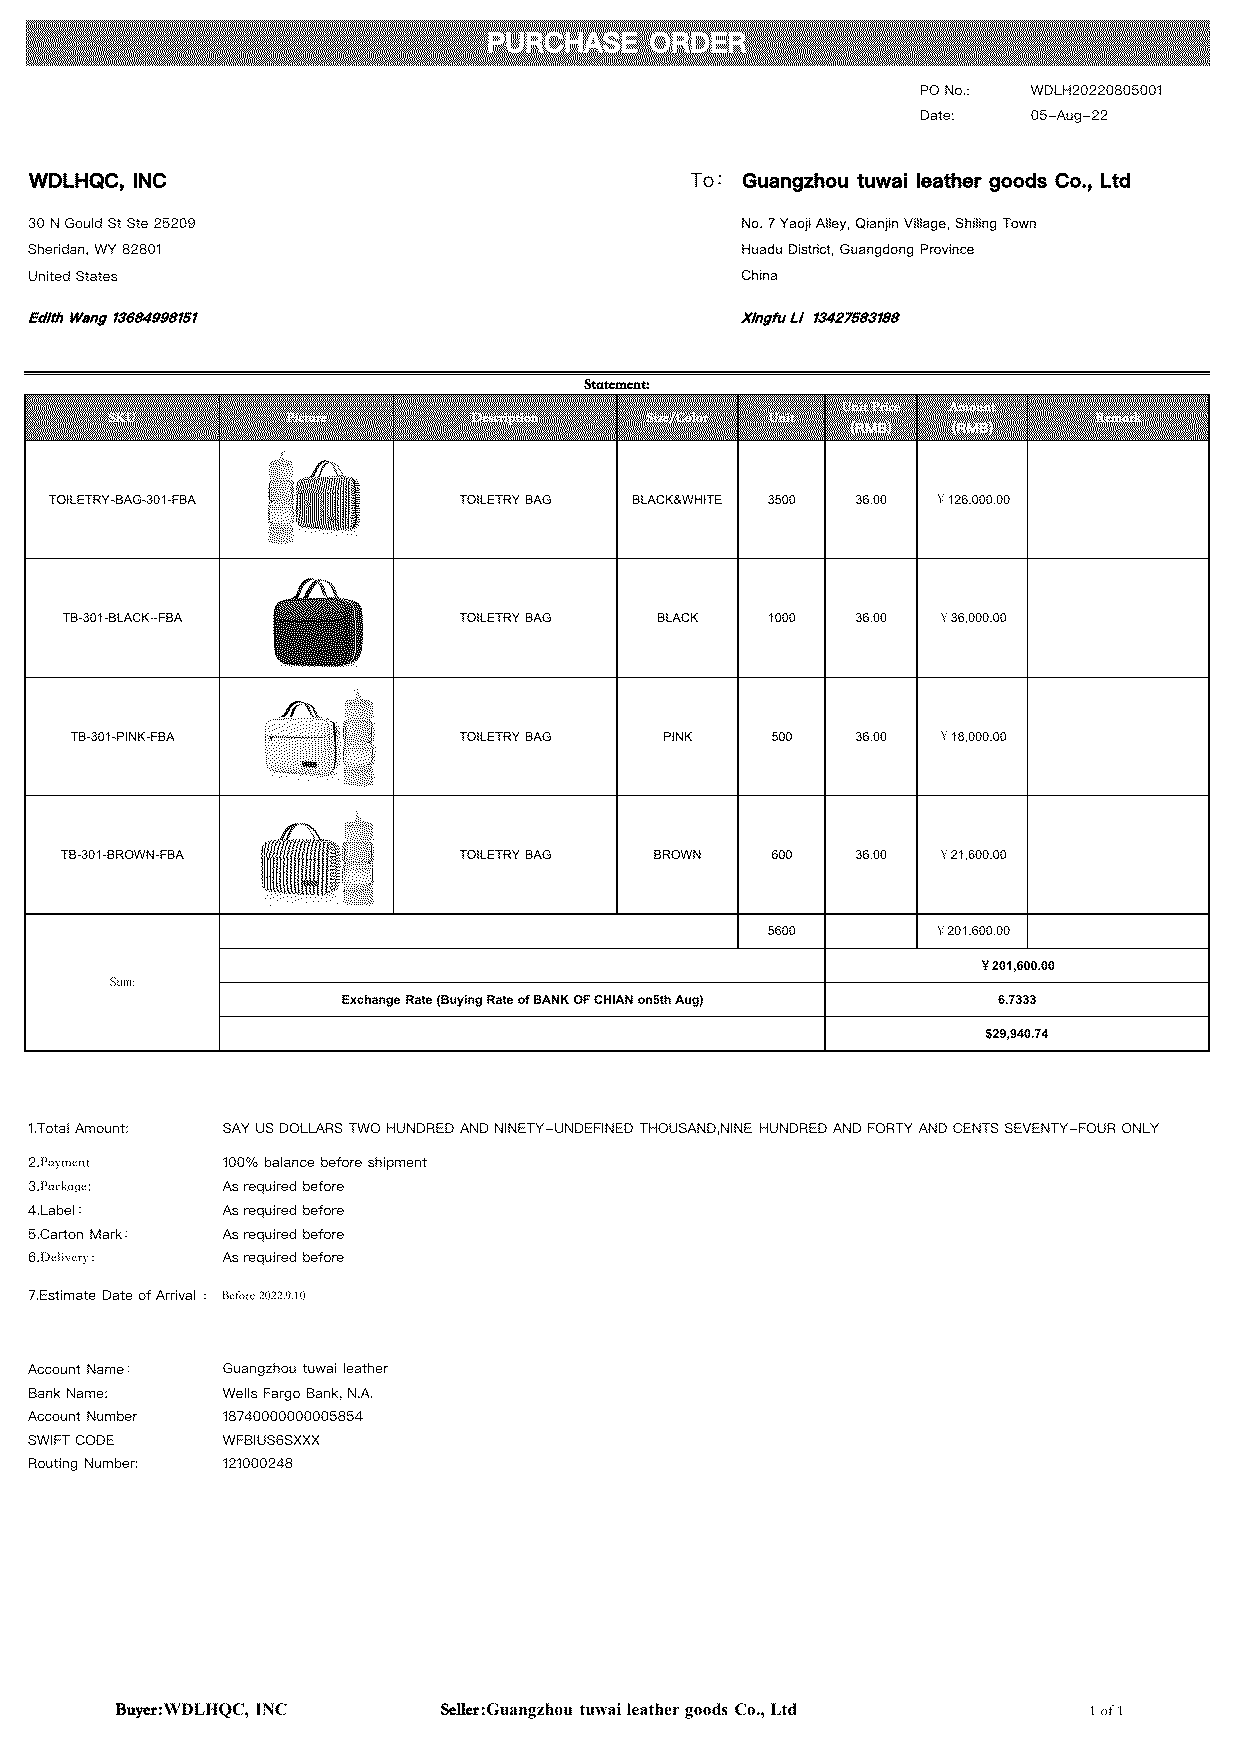

{'receiver_name': 'WDLHQC, INC',
 'supplier_name': 'Guangzhou tuwai leather goods Co., Ltd',
 'invoice_total': 249040.74,
 'invoice_date': '2022/08/05'}

In [5]:
test_path = "./inputs/Sample PDFs/PO-WDLH20220805001.pdf"
imgs = pdf2img(test_path)
imgs = list(map(optimize_img, imgs))
display(imgs[0])
parse_invoice_or_po(imgs)